In [ ]:
from datasets import load_dataset

# ====================== Data Loading ======================
# Etichette: 0 = NEG, 1 = POS
ds = load_dataset("mteb/amazon_polarity")

TRAIN_FRAC = 0.01
TEST_FRAC  = 0.1
SEED = 42

train_sub = ds["train"].train_test_split(train_size=TRAIN_FRAC, seed=SEED)["train"]
test_sub  = ds["test"].train_test_split(train_size=TEST_FRAC,  seed=SEED)["train"]

train = train_sub.to_pandas()[["text", "label"]].rename(columns={"label":"y"}).dropna()
test  = test_sub.to_pandas()[["text", "label"]].rename(columns={"label":"y"}).dropna()

print("Train size:", len(train), "| Test size:", len(test))
print("Train label balance:\n", train["y"].value_counts(normalize=True).round(3))
print("Test label balance:\n",  test["y"].value_counts(normalize=True).round(3))


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3599994 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3599994 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3599994 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Train size: 35999 | Test size: 40000
Train label balance:
 y
1    0.5
0    0.5
Name: proportion, dtype: float64
Test label balance:
 y
0    0.502
1    0.498
Name: proportion, dtype: float64


In [ ]:
from matplotlib import pyplot as plt
from sklearn.base import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score


LABELS = [0, 1]  # 0=NEG, 1=POS
LABEL2TXT = {0:"NEG", 1:"POS"}

def evaluate_predictions(y_true: list[int], y_pred: list[int], title: str = "Model"):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    print(f"\n=== {title} ===")
    print("Accuracy:", round(acc, 4))
    print("F1-macro:", round(f1, 4))
    print(classification_report(y_true, y_pred, digits=3))
    plot_confusion_matrix(y_true, y_pred, labels=LABELS, title=f"{title} — Confusion Matrix")

def plot_confusion_matrix(y_true, y_pred, labels=LABELS, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(labels))); ax.set_xticklabels([LABEL2TXT[l] for l in labels], rotation=0)
    ax.set_yticks(np.arange(len(labels))); ax.set_yticklabels([LABEL2TXT[l] for l in labels])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.show()

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def vader_predict(texts: list[str]) -> list[int]:
    preds = []
    for t in texts:
        s = sia.polarity_scores(t)["compound"]
        preds.append(1 if s >= 0.05 else 0)  # 1=POS, 0=NEG
    return preds

pred_vader = vader_predict(test["text"].tolist())
evaluate_predictions(test["y"].values, pred_vader, title="VADER")


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        min_df=3,
        ngram_range=(1, 2),
        max_features=120_000,
        lowercase=True,
        strip_accents=None
    )),
    ("clf", LogisticRegression(
        max_iter=300,
        class_weight="balanced",
        C=2.0,
        solver="liblinear"
    ))
])

tfidf_lr.fit(train["text"], train["y"])
pred_tfidf = tfidf_lr.predict(test["text"])
evaluate_predictions(test["y"].values, pred_tfidf, title="TF-IDF + LogisticRegression")


Running Gemini (test_frac=0.10, batch=8): 100%|██████████| 500/500 [03:20<00:00,  2.50it/s]


=== GEMINI — polarity (test fraction=0.10), size=4000, batch=8 ===
Accuracy: 0.959
F1-macro: 0.9589810389852709
              precision    recall  f1-score   support

         neg      0.945     0.976     0.960      2010
         pos      0.975     0.942     0.958      1990

    accuracy                          0.959      4000
   macro avg      0.960     0.959     0.959      4000
weighted avg      0.959     0.959     0.959      4000



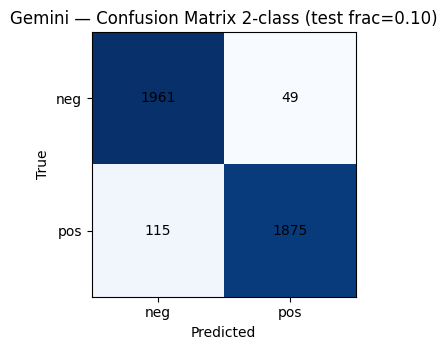

In [15]:
# === Gemini evaluation: polarity neg/pos (batch, seed param) ==================
import os, time, re, random
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import display

# --------------------------------------------------------------------------
# 0) Config Gemini: carica API key da .env, variabile ambiente o Colab
# --------------------------------------------------------------------------
from pathlib import Path
try:
    from dotenv import load_dotenv
    cwd = Path.cwd()
    candidate_dirs = [cwd] + list(cwd.parents)
    env_path = None
    for d in candidate_dirs:
        cand = d / '.env'
        if cand.exists():
            env_path = cand
            break
    if env_path:
        load_dotenv(dotenv_path=env_path, override=False)
except Exception as e:
    print(f"[INFO] Impossibile caricare .env automaticamente: {e}")

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
if not GEMINI_API_KEY:
    try:
        from google.colab import userdata  # type: ignore
        GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    except Exception:
        GEMINI_API_KEY = None
if not GEMINI_API_KEY:
    try:
        import getpass
        GEMINI_API_KEY = getpass.getpass("Inserisci GEMINI_API_KEY: ")
    except Exception:
        raise RuntimeError("GEMINI_API_KEY non trovato. Definisci la variabile d'ambiente o un file .env.")
if not GEMINI_API_KEY:
    raise RuntimeError("GEMINI_API_KEY non valido (vuoto).")

import google.generativeai as genai
try:
    genai.configure(api_key=GEMINI_API_KEY)
except Exception as e:
    raise RuntimeError(f"Errore nella configurazione di google.generativeai: {e}")

MODEL_NAME = "gemini-2.5-flash-lite"

# --------------------------------------------------------------------------
# 1) Prompt: risposta SOLO in {neg, pos}
# --------------------------------------------------------------------------
INSTRUCTIONS = """You are a sentiment classifier.
For EACH review, respond with EXACTLY ONE word among:
neg,pos

Rules:
- No explanations, no punctuation, no quotes.
- Output: one label per line, in the same order as the reviews.
"""

def build_header() -> str:
    return INSTRUCTIONS

# --------------------------------------------------------------------------
# 2) Chiamata a Gemini in batch (ritorna ['neg'|'pos', ...])
# --------------------------------------------------------------------------
LABEL_RE = re.compile(r"\b(neg|pos)\b", re.IGNORECASE)

def _coerce_label(s: str) -> str:
    s = (s or "").strip().lower()
    s = re.sub(r"[^a-z]", "", s)
    if s in ("neg", "pos"): return s
    if s.startswith("neg"): return "neg"
    if s.startswith("pos"): return "pos"
    if "negative" in s: return "neg"
    if "positive" in s: return "pos"
    return "neg"  # fallback: meglio sbagliare su negativo

def gemini_batch_polarity(reviews: list[str], max_retries=4, sleep_base=0.6) -> list[str]:
    """
    Classify multiple reviews in a single call (neg/pos).
    Returns a list of strings in {'neg','pos'} in the same input order.
    """
    header = build_header()
    lines = [header, "Now classify these reviews (one label per line in the same order):"]
    for i, rev in enumerate(reviews, 1):
        rev_oneline = " ".join(str(rev).split())
        lines.append(f"{i}) Review: \"{rev_oneline}\"\nLabel:")

    prompt = "\n".join(lines)

    gen_cfg = genai.GenerationConfig(
        temperature=0,
        max_output_tokens=max(64, 3 * len(reviews) + 16),
    )
    model = genai.GenerativeModel(MODEL_NAME, generation_config=gen_cfg)

    for attempt in range(max_retries):
        try:
            resp = model.generate_content(prompt)
            raw = (getattr(resp, "text", "") or "").strip()
            out_lines = [l.strip() for l in raw.splitlines() if l.strip()]
            preds = []
            for l in out_lines:
                m = LABEL_RE.search(l)
                if m:
                    preds.append(_coerce_label(m.group(1)))
            if len(preds) >= len(reviews):
                return preds[:len(reviews)]
        except Exception as e:
            wait = sleep_base * (2 ** attempt) + random.random() * 0.1
            print(f"[Retry {attempt+1}] Error: {e}. Waiting {wait:.2f}s")
            time.sleep(wait)

    return ["neg"] * len(reviews)  # fallback

def gemini_label_polarity(review: str) -> str:
    return gemini_batch_polarity([review])[0]

# --- PARAMS (tutti qui, comodi) ---
SEED = 42            # riproducibilità
TEST_FRACTION = 0.1 # frazione del test da valutare (0<frac<=1; 1.0 = full test)
BATCH_SIZE = 8       # dimensione batch per chiamate al modello
USE_STRATIFY = True  # mantieni la distribuzione di y nel sottoinsieme

# --------------------------------------------------------------------------
# 3) Evaluation on a PARAMETRIC FRACTION of the test set (no checkpoints, no file writes)
# --------------------------------------------------------------------------
from sklearn.model_selection import train_test_split

def pick_test_fraction(df: pd.DataFrame, frac: float, seed: int = 42, stratify: bool = True) -> pd.DataFrame:
    """
    Restituisce una sotto-parte di df di dimensione pari a 'frac' (0<frac<=1).
    Se stratify=True, mantiene la distribuzione di df['y'].
    """
    if not (0 < frac <= 1):
        raise ValueError(f"TEST_FRACTION deve essere in (0,1], ricevuto {frac}")
    if frac == 1:
        return df
    y = df["y"] if stratify else None
    _, df_sub = train_test_split(
        df,
        test_size=frac,
        random_state=seed,
        stratify=y if stratify else None,
        shuffle=True
    )
    return df_sub.sort_index()  # opzionale: ripristina ordine originale

# Usa il dataset di test già presente (test), colonna 'text' e 'y'
test_subset = pick_test_fraction(test, TEST_FRACTION, seed=SEED, stratify=USE_STRATIFY)
texts_all = test_subset["text"].astype(str).tolist()
y_true_all = ["neg" if x == 0 else "pos" for x in test_subset["y"].astype(int).tolist()]

random.seed(SEED)

preds_all: list[str] = []
rng = range(0, len(texts_all), BATCH_SIZE)
for i in tqdm(rng, desc=f"Running Gemini (test_frac={TEST_FRACTION:.2f}, batch={BATCH_SIZE})"):
    batch = texts_all[i:i+BATCH_SIZE]
    preds = gemini_batch_polarity(batch)
    preds_all.extend(preds)

assert len(preds_all) == len(texts_all), \
    f"Length mismatch: preds={len(preds_all)} vs texts={len(texts_all)}"

# --------------------------------------------------------------------------
# 4) Metrics (in-memory only)
# --------------------------------------------------------------------------
CLASSES_2 = ["neg", "pos"]

acc = accuracy_score(y_true_all, preds_all)
f1m = f1_score(y_true_all, preds_all, average="macro")
print(f"\n=== GEMINI — polarity (test fraction={TEST_FRACTION:.2f}), size={len(texts_all)}, batch={BATCH_SIZE} ===")
print("Accuracy:", acc)
print("F1-macro:", f1m)
print(classification_report(y_true_all, preds_all, labels=CLASSES_2, digits=3))

df_out = pd.DataFrame({
    "gold_polarity": y_true_all,
    "pred_polarity": preds_all,
    "text": texts_all
})

cm = confusion_matrix(y_true_all, preds_all, labels=CLASSES_2)
plt.figure(figsize=(4.2,3.6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title(f"Gemini — Confusion Matrix 2-class (test frac={TEST_FRACTION:.2f})")
plt.xticks(range(len(CLASSES_2)), CLASSES_2)
plt.yticks(range(len(CLASSES_2)), CLASSES_2)
for (r, c), v in np.ndenumerate(cm):
    plt.text(c, r, str(v), ha='center', va='center', color='black')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

metrics = {"accuracy": acc, "f1_macro": f1m, "classes": CLASSES_2, "confusion_matrix": cm}